# Matching Algorithm Model Comparison

Here you will find a comprehensive comparison using our existing match data and testing on various models along with annotation describing each model. The next chunk of code here is just importing various libraries as well as loading in our data.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from numpy.random import randn
from numpy.matlib import repmat

from scipy.stats import norm
from scipy.optimize import fmin
from scipy.special import erf

from patsy import dmatrices

from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, LassoCV, RidgeClassifierCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
def plot_roc(X_test, y_test, model):
    print(y_test.shape)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_test.shape[1] + 1):
        fpr[i], tpr[i], thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
def array_vector(col):
    return np.array(str(col))

arrayerize = np.vectorize(array_vector)

def one_hot_encode(df, column, labels_column=None, whitelist=[]):
    # This is gross but since strings are iterable, we have to wrap them in a list
    # in order for the binarizer to parse the labels as strings and not chars
    labels = arrayerize(pd.DataFrame(df[column]))
    terms = arrayerize(pd.DataFrame(list(set(df[column]))))

    mlb = MultiLabelBinarizer()
    mlb.fit(terms)
    mlb.transform(labels)
    columns = [ f'{column}-{classname}' for classname in  mlb.classes_]

    encoded = pd.DataFrame(mlb.transform(labels), columns=columns, index=df[column].index)

    df.drop(column, axis=1, inplace=True)
    return df.join(encoded)

In [4]:
firms = pd.read_csv('../match-data/match-v1/firms.csv')
jobs = pd.read_csv('../match-data/match-v1/job-openings.csv')
jobs_parent = pd.read_csv('../match-data/match-v1/job-openings-parent.csv')
job_seekers = pd.read_csv('../match-data/match-v1/job-seekers.csv')
matches = pd.read_csv('../match-data/match-v1/matches.csv')
matches_parent = pd.read_csv('../match-data/match-v1/matches-parent.csv')

ignore = ['number', 'caseid', 'parent_caseid', 'job_id', 'hired_yes_no', 'quit', 'fired']

job_seekers.columns = ['JS-' + c if c not in ignore else c for c in job_seekers.columns]
firms.columns = ['JOB-' + c if c not in ignore else c for c in firms.columns]
jobs.columns = ['JOB-' + c if c not in ignore else c for c in jobs.columns]
matches.columns = ['MATCH-' + c if c not in ignore else c for c in matches.columns]

matches_merged = pd.merge(matches, matches_parent, on='number')
jobs_merged = pd.merge(jobs, jobs_parent, on='number')

In [5]:
categorical_columns = ["JS-gender", "JS-highest_edu_level", "JS-nationality", "JS-gendermix_not_allowed", "JS-benefit1", "JS-benefit2", "JS-city", "JS-english_proficiency", "JS-impairments", "JS-major", "JS-opposite_gender_coworkers", "JS-opposite_gender_manager", "JS-first_job_field_preference", "JS-second_job_field_preference", "JOB-bus_covered", "JOB-childcare_subsidy_offered", "JOB-dorm_covered", "JOB-driving_ability_required", "JOB-education_required", "JOB-english_proficiency_required", "JOB-female_requied", "JOB-free_meals_at_wok", "JOB-health_insurance_offered", "JOB-hearing_disability_accepted", "JOB-housing_subsidy_offered", "JOB-it_proficiency_required", "JOB-job_category", "JOB-job_description", "JOB-job_production", "JOB-jordanian_experience_required", "JOB-literacy_required", "JOB-male_required", "JOB-meal_subsidy_offered", "JOB-night_shifts_required", "JOB-noncognitive_skill_preference1", "JOB-noncognitive_skill_preference2", "JOB-numeracy_requied", "JOB-physical_disability_accepted", "JOB-physical_work_abilities_required", "JOB-problem_solving_required", "JOB-school_subsidy_offered", "JOB-specialization_required", "JOB-speech_disability_accepted", "JOB-syrian_considered", "JOB-transport_subsidy_offered", "JOB-visual_disability_accepted", "JOB-work_permit_offered",]
all_columns = ["JS-age", "JS-gender", "JS-highest_edu_level", "JS-will_work_night_shift", "JS-nationality", "JS-gendermix_not_allowed", "JS-will_work_qiz", "JS-arab_coworkers", "JS-benefit1", "JS-benefit2", "JS-city", "JS-daily_hours_willing_to_work", "JS-days_willing_train_unpaid", "JS-distance_willing_to_travel", "JS-english_proficiency", "JS-experience_clerical_work", "JS-experience_factory", "JS-experience_management_work", "JS-experience_manual_labor", "JS-experience_professional_work", "JS-follow_up_agreement", "JS-impairments", "JS-major", "JS-nonarab_coworkers", "JS-opposite_gender_coworkers", "JS-opposite_gender_manager", "JS-weekly_days_willing_to_work", "JS-will_live_in_dorm", "JS-will_train_unpaid", "JS-years_education", "JS-years_exp", "JS-first_job_field_preference", "JS-rwage1", "JS-second_job_field_preference", "MATCH-hh_income", "MATCH-interest_applying", "MATCH-num_children", "MATCH-personal_income", "JOB-bus_covered", "JOB-childcare_subsidy_offered", "JOB-dorm_covered", "JOB-driving_ability_required", "JOB-education_required", "JOB-english_proficiency_required", "JOB-female_requied", "JOB-free_meals_at_wok", "JOB-health_insurance_offered", "JOB-hearing_disability_accepted", "JOB-housing_subsidy_offered", "JOB-it_proficiency_required", "JOB-job_category", "JOB-job_description", "JOB-job_production", "JOB-jordanian_experience_required", "JOB-literacy_required", "JOB-male_required", "JOB-meal_subsidy_offered", "JOB-night_shifts_required", "JOB-noncognitive_skill_preference1", "JOB-noncognitive_skill_preference2", "JOB-num_vacancies", "JOB-numeracy_requied", "JOB-physical_disability_accepted", "JOB-physical_work_abilities_required", "JOB-problem_solving_required", "JOB-school_subsidy_offered", "JOB-specialization_required", "JOB-speech_disability_accepted", "JOB-syrian_considered", "JOB-transport_subsidy_offered", "JOB-visual_disability_accepted", "JOB-wage_offered", "JOB-work_permit_offered", "JOB-years_experience_required", 'hired_yes_no', 'quit', 'fired']
scalar_columns = ["JS-age", "JS-daily_hours_willing_to_work", "JS-days_willing_train_unpaid", "JS-distance_willing_to_travel", "JS-years_education", "JS-years_exp", "JS-rwage1", "MATCH-hh_income", "JS-num_children", "JS-personal_income", "JOB-num_vacancies", "JOB-wage_offered", "MATCH-hh_income",  "MATCH-num_children", "MATCH-personal_income",]

In [6]:
job_seekers['parent_case_id'] = job_seekers['caseid']

In [7]:
merged = pd.merge(job_seekers, matches_merged, on='parent_case_id')
merged = pd.merge(merged, jobs_merged, on='job_id')

merged.to_csv('../match-data/match-v1/merged.csv')

In [8]:
formatted = pd.DataFrame()
for col in all_columns:
    formatted[col] = merged[col]

dvs = ['hired_yes_no', 'quit', 'fired']

for col in all_columns:
    if col not in scalar_columns and col not in dvs:
        print(col)
        formatted = one_hot_encode(formatted, col)

for col in formatted.columns:
    # TODO: Change this
    formatted[col] = formatted[col].replace(['---'], 0)
    
formatted.to_csv('../match-data/match-v1/formatted.csv')

JS-gender
JS-highest_edu_level
JS-will_work_night_shift
JS-nationality
JS-gendermix_not_allowed
JS-will_work_qiz
JS-arab_coworkers
JS-benefit1
JS-benefit2
JS-city
JS-english_proficiency
JS-experience_clerical_work
JS-experience_factory
JS-experience_management_work
JS-experience_manual_labor
JS-experience_professional_work
JS-follow_up_agreement
JS-impairments
JS-major
JS-nonarab_coworkers
JS-opposite_gender_coworkers
JS-opposite_gender_manager
JS-weekly_days_willing_to_work
JS-will_live_in_dorm
JS-will_train_unpaid
JS-first_job_field_preference
JS-second_job_field_preference
MATCH-interest_applying
JOB-bus_covered
JOB-childcare_subsidy_offered
JOB-dorm_covered
JOB-driving_ability_required
JOB-education_required
JOB-english_proficiency_required
JOB-female_requied
JOB-free_meals_at_wok
JOB-health_insurance_offered
JOB-hearing_disability_accepted
JOB-housing_subsidy_offered
JOB-it_proficiency_required
JOB-job_category
JOB-job_description
JOB-job_production
JOB-jordanian_experience_requir

In [9]:
formatted['hired_yes_no'] = formatted['hired_yes_no'].fillna(0)
formatted['hired_yes_no'] = formatted['hired_yes_no'].replace(['---'], 0)

formatted['quit'] = formatted['quit'].fillna(0)
formatted['quit'] = formatted['quit'].replace(['---'], 0)
formatted['quit'] = formatted['quit'].replace(['no'], 0)
formatted['quit'] = formatted['quit'].replace(['yes'], 1)

formatted['fired'] = formatted['fired'].fillna(0)
formatted['fired'] = formatted['fired'].replace(['---'], 0)
formatted['fired'] = formatted['fired'].replace(['no'], 0)
formatted['fired'] = formatted['fired'].replace(['yes'], 1)

formatted['hired_yes_no'] = formatted['hired_yes_no'].astype(bool)
formatted['quit'] = formatted['quit'].astype(bool)
formatted['fired'] = formatted['fired'].astype(bool)

outcomes = pd.DataFrame()
outcomes['retained'] = formatted['hired_yes_no'] & ~(formatted['quit'] | formatted['fired'])
outcomes['hired'] = formatted['hired_yes_no']
y = pd.DataFrame()
o = []
for index, row in outcomes.iterrows():
    if row['hired'] and row['retained']:
        o.append(2)
    elif not row['hired'] and not row['retained']:
        o.append(0)
    elif row['hired'] and not row['retained']:
        o.append(1)

# y['outcomes'] = o
y['outcomes'] = outcomes['hired']

In [10]:
formatted = formatted.drop(dvs, axis=1)

In [11]:
to_drop = []
for col in formatted.columns:
    if col in scalar_columns:
        formatted[col] = formatted[col].astype(float)
        mean = formatted[col].mean()
        formatted[col] = formatted[col].replace(['---'], mean)
        formatted[col] = formatted[col].fillna(mean)
    else:
        formatted[col] = formatted[col].fillna(0)
        formatted[col] = formatted[col].astype(int)
        formatted[col] = formatted[col].replace(['---'], 0)
    
    if col.endswith('---') or col.endswith('nan'):
        to_drop.append(col)

formatted = formatted.drop(columns=to_drop)

In [12]:
y=y.astype('int')
y.to_csv('../match-data/match-v1/y.csv')

In [13]:
formatted.to_csv('../match-data/match-v1/X.csv')
X = formatted

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [15]:
transformer = ReduceVIF(thresh=10.0)

# Only use 10 columns for speed in this example
X = transformer.fit_transform(X, y)

ReduceVIF fit
ReduceVIF transform


/home/nolski/code/tashbeek/venv/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping JOB-wage_offered with vif=inf
Dropping JS-gender-female with vif=inf
Dropping JS-highest_edu_level-bachelors with vif=inf
Dropping JS-highest_edu_level-college with vif=inf
Dropping JS-highest_edu_level-intermediate with vif=inf
Dropping JS-highest_edu_level-masters with vif=inf
Dropping JS-highest_edu_level-none with vif=inf
Dropping JS-will_work_night_shift-0 with vif=inf
Dropping JS-nationality-jordanian with vif=inf
Dropping JS-will_work_qiz-0 with vif=inf
Dropping JS-arab_coworkers-0 with vif=inf
Dropping JS-benefit1-bus_service with vif=inf
Dropping JS-benefit2-bus_service with vif=inf
Dropping JS-city-amman with vif=inf
Dropping JS-english_proficiency-extended_conversation with vif=inf
Dropping JS-english_proficiency-literate with vif=inf
Dropping JS-experience_clerical_work-0 with vif=inf
Dropping JS-experience_factory-0 with vif=inf
Dropping JS-experience_management_work-0 with vif=inf
Dropping JS-experience_manual_labor-0 with vif=inf
Dropping JS-follow_up_agreement-

In [16]:
X.to_csv('../match-data/match-v1/X-vif.csv')

In [35]:
X = pd.read_csv('../match-data/match-v1/X-vif.csv')

## Random Forest

Here we train a random forest model with a maximum tree depth of 10 using 100 decision trees in our forest on our training set. We train and test this 100 times using random splits between our train and test. The average accuracy of those 100 tests is logged in the output below. As you can see it's around 75% accuracy.

In [36]:
from sklearn.ensemble import RandomForestClassifier
scores = []
model = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100)

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    model.fit(X_train, y_train)
    s = model.score(X_test, y_test)
    scores.append(s)
    
sum(scores) / len(scores)

0.7692592592592596

(54, 1)


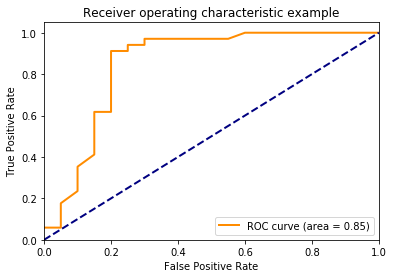

In [37]:
plot_roc(X_test, y_test, model)

To get a better idea of what our end result decision tree looks like, the below image (if it's too small to read, right click the image and click "view image") gives us a visual representation of our decision tree. Each property being evaluated is either prefixed with "JS-" (job seeker), "JOB-", or "MATCH-" to denote which data set it came from. For categorical variables, the category is at the end of the property.

For instance `JS-english_proficiency_required-no <= 0.5` means if the job seeker answered `no` to `english_proficiency_required` then choose the node on the right, otherwise, choose the node on the left 

The leaf nodes are essentially what class we think the candidate will belong to with this given match. 

 - Class `0` is rejected
 - Class `1` is hired but not retained
 - Class `2` is both hired and retained
 
Retained in the case of our training set is all candidates that have been retained to date *not* retained for 3 months

In [38]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
model.fit(X_train, y_train)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = [str(c) for c in model.classes_],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

The table output of the below code shows the predicted probabilities of our test set (given the above decision tree) along with both the true-DV as well as our prediciton of the DV

In [39]:
probs = model.predict_proba(X_test)
predictions = pd.DataFrame(data=probs, columns=['0', '1'])

predictions['true-DV'] = [v[0] for v in y_test.values]
predictions['predicted-DV'] = model.predict(X_test)

In [40]:
importances = {}
for i, importance in enumerate(model.feature_importances_):
    importances[X.columns[i]] = importance
    
importances

c = {}
for k, v in importances.items():
    c[k] = [v]
    

importance_frame = pd.DataFrame.from_dict(c)
importance_frame.to_csv('../match-data/match-v1/random-forest-importance.csv')

# GBRT

Below we have done the same average of 100 tests using a GBRT model

In [41]:
scores = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))

sum(scores) / len(scores)

0.7564814814814811

(54, 1)


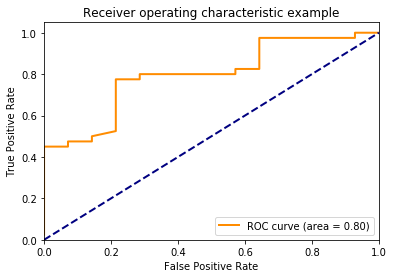

In [42]:
plot_roc(X_test, y_test, model)

## LASSO CV

Below we have done the same average of 100 tests using a LASSO model with cross validation. I have no idea why this model is performing so bad

In [43]:
def lasso_regression(X_train, y_train, X_test, y_test, alpha, models_to_plot={}):
    #Fit the model
    print('1')
    model = LassoCV(alphas=[alpha], normalize=True, max_iter=1e5)
    print('fitting')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(len(y_pred))
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        print('2')
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'], y_pred)
        plt.plot(data['x'], y_test, '.')
        plt.title('Plot for alpha: %.3g' % alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_test.values.ravel())**2)
    ret = [rss]
    ret.extend([model.intercept_])
    ret.extend(model.coef_)
    print(len(ret))
    return ret

# K Best Feature Elimination

Below we are using K-Best (k = 10) as a means of selecting features for a logit model. The output shows the columns which were selected

In [44]:
from sklearn.feature_selection import SelectKBest

# Create and fit selector
selector = SelectKBest(chi2, k=20)
selector.fit(X, y)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices=True)
cols = []
for i, c in enumerate(X.columns):
    if i in idxs_selected:
        cols.append(c)

cols

['JS-days_willing_train_unpaid',
 'JS-years_exp',
 'MATCH-hh_income',
 'MATCH-num_children',
 'MATCH-personal_income',
 'JS-will_work_night_shift-1',
 'JS-benefit2-transportation_subsidy',
 'JS-city-other',
 'JS-experience_professional_work-1',
 'JS-major-it',
 'JS-weekly_days_willing_to_work-7',
 'JS-first_job_field_preference-repair',
 'JOB-education_required-intermediate',
 'JOB-it_proficiency_required-none',
 'JOB-noncognitive_skill_preference1-independent',
 'JOB-noncognitive_skill_preference2-conscientiousness',
 'JOB-noncognitive_skill_preference2-emotional_stability',
 'JOB-specialization_required-manufacturing_tech',
 'JOB-speech_disability_accepted-yes',
 'JOB-transport_subsidy_offered-yes']

### Accuracy using top 10 k-best features


Below we have done the same average of 100 tests using a logit model with cross validation using only the 10 features selected using K-Best.

In [45]:
model = LogisticRegressionCV(max_iter=1000)

scores = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    XX_train = pd.DataFrame()
    XX_test = pd.DataFrame()
    for c in cols:
        XX_train[c] = X_train[c]
        XX_test[c] = X_test[c]

    model.fit(XX_train, y_train)
    scores.append(model.score(XX_test, y_test))

sum(scores) / len(scores)

0.7738888888888888

(54, 1)


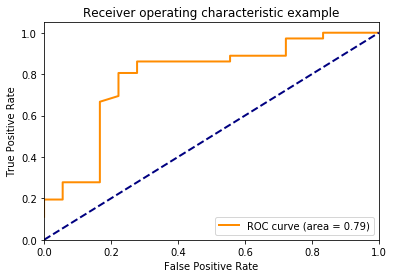

In [46]:
plot_roc(XX_test, y_test, model)

### Export Coefs & p-values to csv

this is just exporting the coefs, p-values, and odds ratio to csv

In [47]:
coef_dict = {}
for coef, feat in zip(model.coef_[0], cols):
    coef_dict[feat] = coef
    
c = {}
for k, v in coef_dict.items():
    c[k] = [v]
    

coef_frame = pd.DataFrame.from_dict(c)
sorted_frame = coef_frame.columns[coef_frame.ix[coef_frame.last_valid_index()].argsort()]
coef_frame.to_csv('../match-data/match-v1/kbest-coefs.csv')

odds_ratios = np.exp(coef_frame)
scores, pvalues = chi2(X, y)

p_dict = {}
for pvalue, feat in zip(pvalues, cols):
    p_dict[feat] = pvalue
    
c = {}
for k, v in p_dict.items():
    c[k] = [v]
    

pval_frame = pd.DataFrame.from_dict(c)
sorted_frame = pval_frame.columns[pval_frame.ix[pval_frame.last_valid_index()].argsort()]
pval_frame.to_csv('../match-data/match-v1/kbest-pvalues.csv')

combined = coef_frame.append(pval_frame).append(np.exp(odds_ratios))
combined.to_csv('../match-data/match-v1/kbest-combined.csv')

# Recursive Feature Elimination

Here we are using recursive feature elimination in order to select our features. As you can see the features are quite different from K-Best

In [48]:
model = LogisticRegressionCV(max_iter=1000)
from sklearn.feature_selection import RFE
selector = RFE(model, 20, step=4)
selector.fit(X, y)

RFE(estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
  n_features_to_select=20, step=4, verbose=0)

In [49]:
len(selector.support_)
cols = []
for i, v in enumerate(selector.support_):
    if v:
        cols.append(X.columns[i])

cols

['JS-highest_edu_level-primary',
 'JS-will_work_night_shift-1',
 'JS-benefit1-transportation_subsidy',
 'JS-benefit2-transportation_subsidy',
 'JS-english_proficiency-simple_phrases',
 'JS-experience_professional_work-1',
 'JS-will_train_unpaid-0',
 'JS-first_job_field_preference-janitor',
 'JS-first_job_field_preference-repair',
 'JS-first_job_field_preference-sales',
 'JS-second_job_field_preference-protective_science',
 'JS-second_job_field_preference-sales',
 'JOB-education_required-intermediate',
 'JOB-it_proficiency_required-none',
 'JOB-job_production-printing_worker',
 'JOB-noncognitive_skill_preference1-emotional_stability',
 'JOB-noncognitive_skill_preference2-conscientiousness',
 'JOB-noncognitive_skill_preference2-emotional_stability',
 'JOB-speech_disability_accepted-yes',
 'JOB-transport_subsidy_offered-yes']

### Accuracy using top 20 RFE features

Below we are fitting a logit with these features

In [50]:
model = LogisticRegressionCV(max_iter=1000)

scores = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    XX_train = pd.DataFrame()
    XX_test = pd.DataFrame()
    for c in cols:
        XX_train[c] = X_train[c]
        XX_test[c] = X_test[c]

    model.fit(XX_train, y_train)
    scores.append(model.score(XX_test, y_test))

sum(scores) / len(scores)

0.7938888888888884

(54, 1)


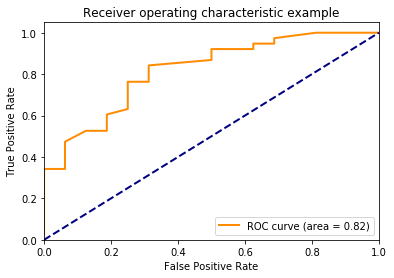

In [51]:
plot_roc(XX_test, y_test, model)

In [52]:
coef_dict = {}
for coef, feat in zip(model.coef_[0], cols):
    coef_dict[feat] = coef
    
c = {}
for k, v in coef_dict.items():
    c[k] = [v]
    

coef_frame = pd.DataFrame.from_dict(c)
sorted_frame = coef_frame.columns[coef_frame.ix[coef_frame.last_valid_index()].argsort()]
coef_frame.to_csv('../match-data/match-v1/rfe-coefs.csv')

odds_ratios = np.exp(coef_frame)
scores, pvalues = chi2(X, y)

p_dict = {}
for pvalue, feat in zip(pvalues, cols):
    p_dict[feat] = pvalue
    
c = {}
for k, v in p_dict.items():
    c[k] = [v]
    

pval_frame = pd.DataFrame.from_dict(c)
sorted_frame = pval_frame.columns[pval_frame.ix[pval_frame.last_valid_index()].argsort()]
pval_frame.to_csv('../match-data/match-v1/rfe-pvalues.csv')

combined = coef_frame.append(pval_frame).append(np.exp(odds_ratios))
combined.to_csv('../match-data/match-v1/rfe-combined.csv')

/home/nolski/code/tashbeek/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
